In [78]:
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
pd.options.display.max_columns = None
%matplotlib inline
from IPython.display import display

In [79]:
franchises=pd.read_csv('franchises.csv')

In [80]:
franchises.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      365 non-null    int64  
 1   Title           365 non-null    object 
 2   Distributor     360 non-null    object 
 3   Runtime         365 non-null    float64
 4   Rating          365 non-null    object 
 5   Action          365 non-null    int64  
 6   Adventure       365 non-null    int64  
 7   Biography       365 non-null    int64  
 8   Comedy          365 non-null    int64  
 9   Crime           365 non-null    int64  
 10  Documentary     365 non-null    int64  
 11  Drama           365 non-null    int64  
 12  Family          365 non-null    int64  
 13  History         365 non-null    int64  
 14  Horror          365 non-null    int64  
 15  Music           365 non-null    int64  
 16  Mystery         365 non-null    int64  
 17  Romance         365 non-null    int

In [81]:
#change rating to numerical
franchises['Rating']=franchises['Rating'].replace('G',1).replace(['PG','TV-PG'], 2).replace(['PG-13','TV-14'],3).replace(['R','TV-MA'],4).replace([i for i in franchises['Rating'] if i not in ['G','PG','PG-13','R']],np.nan)

In [82]:
#delete distributor for sake of time
del franchises['Distributor']

In [83]:
franchises.head()

,Unnamed: 0,Title,Runtime,Rating,Action,Adventure,Biography,Comedy,Crime,Documentary,Drama,Family,History,Horror,Music,Mystery,Romance,Sport,Thriller,War,Western,Budget,Domestic_Gross
0,0,Avengers: Endgame,181.0,3,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,400000000,858373000
1,1,Avengers: Infinity War,149.0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,300000000,678815482
2,2,The Avengers,143.0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,225000000,623357910
3,3,The Avengers,143.0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,60000000,23385416
4,4,Avengers: Age of Ultron,141.0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,365000000,459005868


In [84]:
# trying to find most common genres in data set to isolate these as one feature
print(franchises['Action'].value_counts())
print(franchises['Adventure'].value_counts())
print(franchises['Biography'].value_counts())
print(franchises['Comedy'].value_counts())
print(franchises['Crime'].value_counts())
print(franchises['Documentary'].value_counts())
print(franchises['Drama'].value_counts())
print(franchises['Family'].value_counts())
print(franchises['History'].value_counts())
print(franchises['Horror'].value_counts())
print(franchises['Music'].value_counts())
print(franchises['Mystery'].value_counts())
print(franchises['Romance'].value_counts())
print(franchises['Sport'].value_counts())
print(franchises['Thriller'].value_counts())
print(franchises['War'].value_counts())
print(franchises['Western'].value_counts())

1    220
0    145
Name: Action, dtype: int64
1    216
0    149
Name: Adventure, dtype: int64
0    365
Name: Biography, dtype: int64
0    256
1    109
Name: Comedy, dtype: int64
0    317
1     48
Name: Crime, dtype: int64
0    365
Name: Documentary, dtype: int64
0    318
1     47
Name: Drama, dtype: int64
0    336
1     29
Name: Family, dtype: int64
0    365
Name: History, dtype: int64
0    334
1     31
Name: Horror, dtype: int64
0    364
1      1
Name: Music, dtype: int64
0    337
1     28
Name: Mystery, dtype: int64
0    357
1      8
Name: Romance, dtype: int64
0    362
1      3
Name: Sport, dtype: int64
0    290
1     75
Name: Thriller, dtype: int64
0    365
Name: War, dtype: int64
0    365
Name: Western, dtype: int64


In [85]:
#finding the most common genres
franchises['Top Genres'] = franchises['Action'] + franchises['Adventure'] + franchises['Comedy'] + franchises['Thriller'] + franchises['Drama'] + franchises['Crime']

In [86]:
franchises = franchises[['Title','Runtime','Rating','Top Genres','Budget','Domestic_Gross']]

In [87]:
franchises.head()

,Title,Runtime,Rating,Top Genres,Budget,Domestic_Gross
0,Avengers: Endgame,181.0,3,3,400000000,858373000
1,Avengers: Infinity War,149.0,3,2,300000000,678815482
2,The Avengers,143.0,3,2,225000000,623357910
3,The Avengers,143.0,3,2,60000000,23385416
4,Avengers: Age of Ultron,141.0,3,2,365000000,459005868


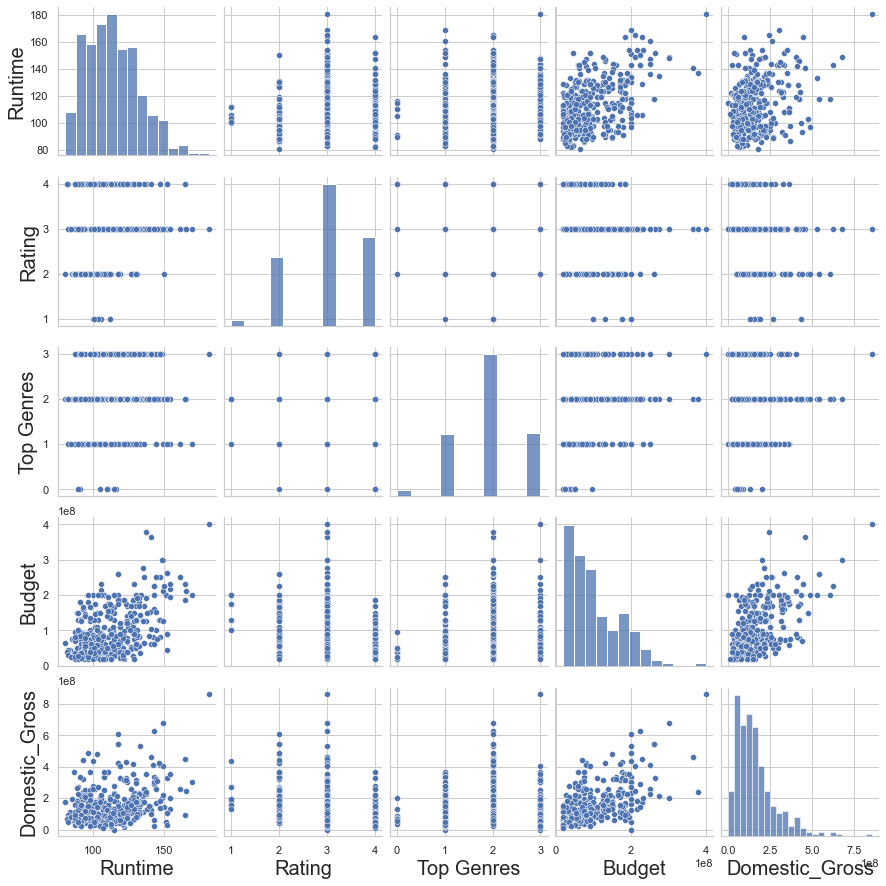

In [88]:
sns.pairplot(franchises)

In [23]:
franchises.corr()

,Runtime,Rating,Top Genres,Budget,Domestic_Gross
Runtime,1.000000,0.111064,0.128509,0.494307,0.321522
Rating,0.111064,1.000000,-0.046352,-0.320472,-0.372865
Top Genres,0.128509,-0.046352,1.000000,0.099047,0.072916
Budget,0.494307,-0.320472,0.099047,1.000000,0.583096
Domestic_Gross,0.321522,-0.372865,0.072916,0.583096,1.000000


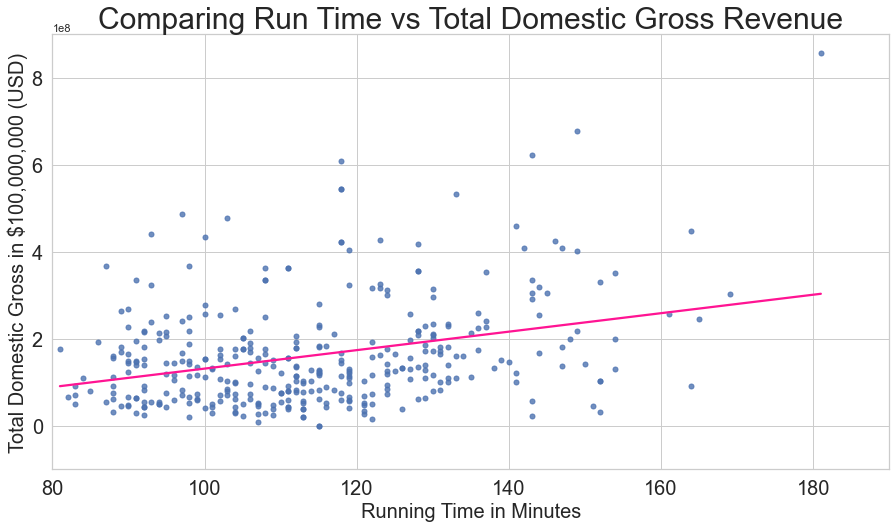

In [40]:
#get some initial eda graphs to determine possible patterns
sns.set( rc = {'figure.figsize' : ( 15, 8 ),  
               'axes.labelsize' : 20 }) 
sns.set_style('whitegrid') 
sns.regplot(data = franchises, x = 'Runtime', y = 'Domestic_Gross', ci = 0, scatter_kws ={'s':25}, line_kws ={'color':'deeppink'});
plt.title('Comparing Run Time vs Total Domestic Gross Revenue', fontsize = 30);
plt.xlabel( "Running Time in Minutes" , size = 20 ) 
plt.ylabel( "Total Domestic Gross in $100,000,000 (USD)" , size = 20 ) 
plt.ylim(-100000000, 900000000)
plt.xlim(80, 190)
plt.yticks(size = 20)
plt.xticks(size = 20)
plt.savefig('Comparing Running Time vs Total Domestic Gross Revenue.svg')

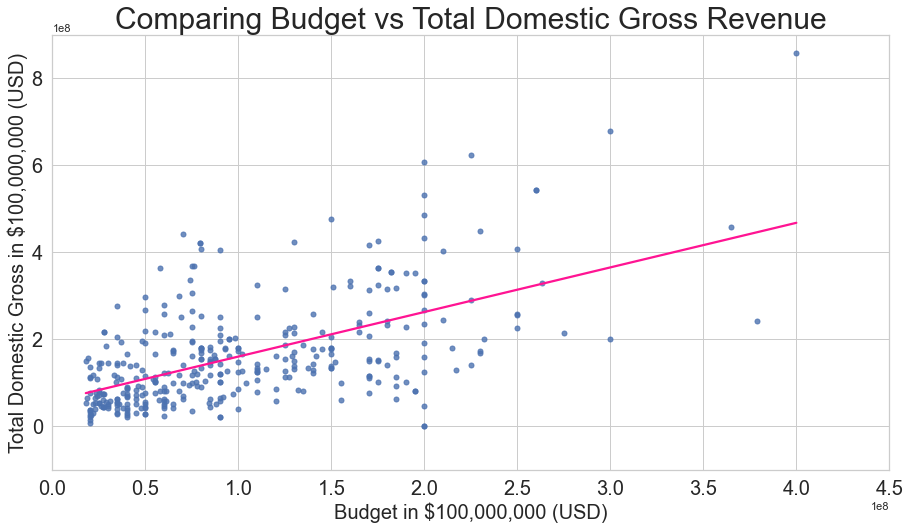

In [36]:
sns.set( rc = {'figure.figsize' : ( 15, 8 ),  
               'axes.labelsize' : 20 }) 
sns.set_style('whitegrid') 
sns.regplot(data = franchises, x = 'Budget', y = 'Domestic_Gross', ci = 0, scatter_kws ={'s':25}, line_kws ={'color':'deeppink'});
plt.title('Comparing Budget vs Total Domestic Gross Revenue', fontsize = 30);
plt.xlabel( "Budget in $100,000,000 (USD)" , size = 20 ) 
plt.ylabel( "Total Domestic Gross in $100,000,000 (USD)" , size = 20 ) 
plt.ylim(-100000000, 900000000)
plt.xlim(0, 450000000)
plt.yticks(size = 20)
plt.xticks(size = 20)
plt.savefig('Comparing Budget vs Total Domestic Gross Revenue.svg')

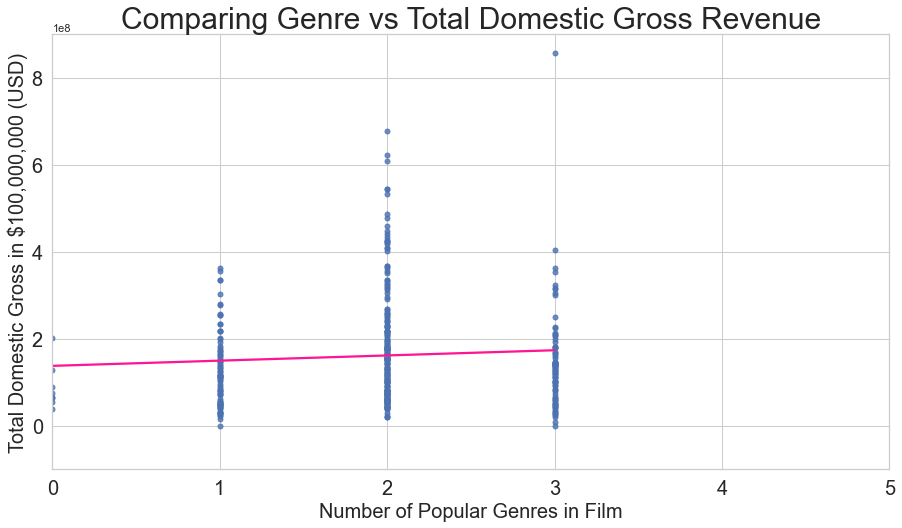

In [39]:
#might not use this one, just made for fun
sns.set( rc = {'figure.figsize' : ( 15, 8 ),  
               'axes.labelsize' : 20 }) 
sns.set_style('whitegrid') 
sns.regplot(data = franchises, x = 'Top Genres', y = 'Domestic_Gross', ci = 0, scatter_kws ={'s':25}, line_kws ={'color':'deeppink'});
plt.title('Comparing Genre vs Total Domestic Gross Revenue', fontsize = 30);
plt.xlabel( "Number of Popular Genres in Film" , size = 20 ) 
plt.ylabel( "Total Domestic Gross in $100,000,000 (USD)" , size = 20 ) 
plt.ylim(-100000000, 900000000)
plt.xlim(0, 5)
plt.yticks(size = 20)
plt.xticks(size = 20)
plt.savefig('Comparing Genre vs Total Domestic Gross Revenue.svg')

In [89]:
Rating = ["Rating"]
Runtime = ["Runtime"]
Top_Genres = ["Top Genres"]
Budget = ["Budget"]

In [96]:
#create baseline model/initial linear regression using all features
#create columns
X_columns = Runtime + Rating + Top_Genres + Budget

In [97]:
y = franchises["Domestic_Gross"]
X = franchises.loc[:,X_columns]

In [98]:
# baseline model & OLS regression summary stats
model = sm.OLS(y,sm.add_constant(X))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Domestic_Gross   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     57.62
Date:                Fri, 11 Jun 2021   Prob (F-statistic):           1.48e-37
Time:                        08:33:14   Log-Likelihood:                -7220.8
No. Observations:                 365   AIC:                         1.445e+04
Df Residuals:                     360   BIC:                         1.447e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.014e+08   3.69e+07      2.744      0.006    2.87e+07    1.74e+08
Runtime     8.722e+05   3.33e+05      2.621      0.009    2.18e+05    1.53e+06
Rating     -3.887e+07   7.25e+06     -5.364      0.000   -5.31e+07   -2.46e+07
Top Genres  1.748e+05   6.83e+06      0.026      0.980   -1.32e+07    1.36e+07
Budget         0.7712      0.092      8.344      0.000       0.589       0.953
==============================================================================
Omnibus:                       71.116   Durbin-Watson:                   1.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              136.321
Skew:                           1.055   Prob(JB):                     2.50e-30
Kurtosis:                       5.124   Cond. No.                     9.10e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.1e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Residual')

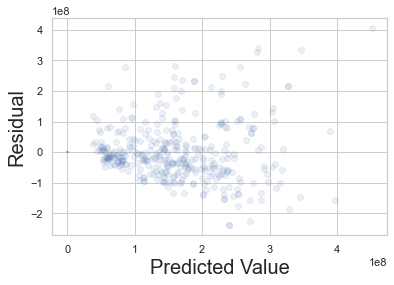

In [99]:
#baseline residual plot

y_pred = results.predict(sm.add_constant(X))

plt.scatter(y_pred,y-y_pred,alpha=.1)
plt.plot(np.linspace(0,600000,1000),np.linspace(0,0,1000))
plt.xlabel('Predicted Value')
plt.ylabel('Residual')

In [101]:
#opted for cross-validation since i have a smaller data set
y = franchises["Domestic_Gross"]
X = franchises.loc[:,X_columns]

X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=3) 

#this helps with the way kf will generate indices below
X, y = np.array(X), np.array(y)


In [102]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_cv = LinearRegression()
lm_reg_cv = Ridge(alpha=1)
kf = KFold(n_splits=5, shuffle=True, random_state = 6)

In [103]:
from sklearn.model_selection import KFold

In [104]:
cv_lm_r2s, cv_lm_reg_r2s = [], [] #collect the validation results for both models

In [105]:
for train_ind, val_ind in kf.split(X,y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #simple linear regression
    lm = LinearRegression()
    lm_reg = Ridge(alpha=1)

    lm.fit(X_train, y_train)
    cv_lm_r2s.append(lm.score(X_val, y_val).round(3))
    
    #ridge with feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val).round(3))

In [106]:
print(f'Simple scores: \t{cv_lm_r2s}')
print(f'Ridge scores: \t{cv_lm_reg_r2s} \n')

print(f'Simple mean cv r^2: {np.mean(cv_lm_r2s):.3f} +- {np.std(cv_lm_r2s):.3f}')
print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')

Simple scores: 	[0.422, 0.506, 0.377, 0.282, 0.372]
Ridge scores: 	[0.421, 0.506, 0.378, 0.283, 0.373] 

Simple mean cv r^2: 0.392 +- 0.073
Ridge mean cv r^2: 0.392 +- 0.072


In [107]:
#running a lasso regression too, just to check it out
lm_lasso_cv = Lasso()
print(cross_val_score(lm_lasso_cv, X, y,
                                cv=kf,       
                                scoring='r2'))
print(np.mean(cross_val_score(lm_lasso_cv, X, y,
                                cv=kf,       
                                scoring='r2')))

[0.4215331  0.50628531 0.37729372 0.28180534 0.37239797]
0.39186308549382776


In [108]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

lm_reg = Ridge(alpha=1)
lm_reg.fit(X_scaled,y)
print(f'Ridge Regression test R^2: {lm_reg.score(X_test_scaled, y_test):.3f}')

Ridge Regression test R^2: 0.182


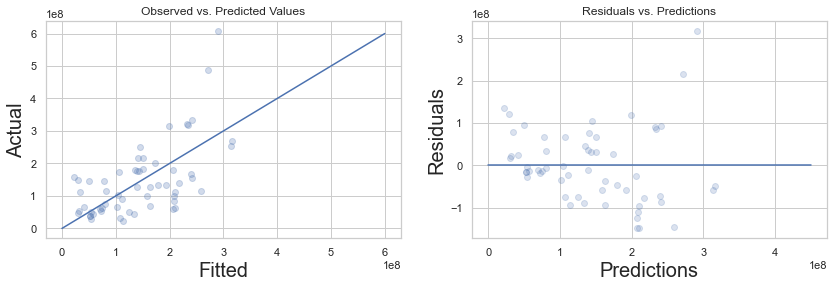

In [109]:
plt.figure(figsize=(14,4))

# Plotting predicted vs. observed
y_pred = lm.predict(X_val)
plt.subplot(1, 2, 1)
plt.scatter(y_pred, y_val, alpha=0.25)
plt.plot([0, 600000000], [0, 600000000])
plt.xlabel('Fitted')
plt.ylabel('Actual')
plt.title("Observed vs. Predicted Values")
plt.savefig("actual_vs_observed.pdf")

# Residuals
lm_residuals = y_val - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_pred, lm_residuals, alpha=.2)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.plot([0,450000000], [0, 0])
plt.title("Residuals vs. Predictions")
plt.savefig("residuals.pdf");

# slight improvement from before on residual plot

In [115]:
# Coefficients for each feature
list(zip(X_columns,lm.coef_))

[('Runtime', 923810.2456073809),
 ('Rating', -38145987.28072484),
 ('Top Genres', 6810692.214298202),
 ('Budget', 0.8714616110189066)]

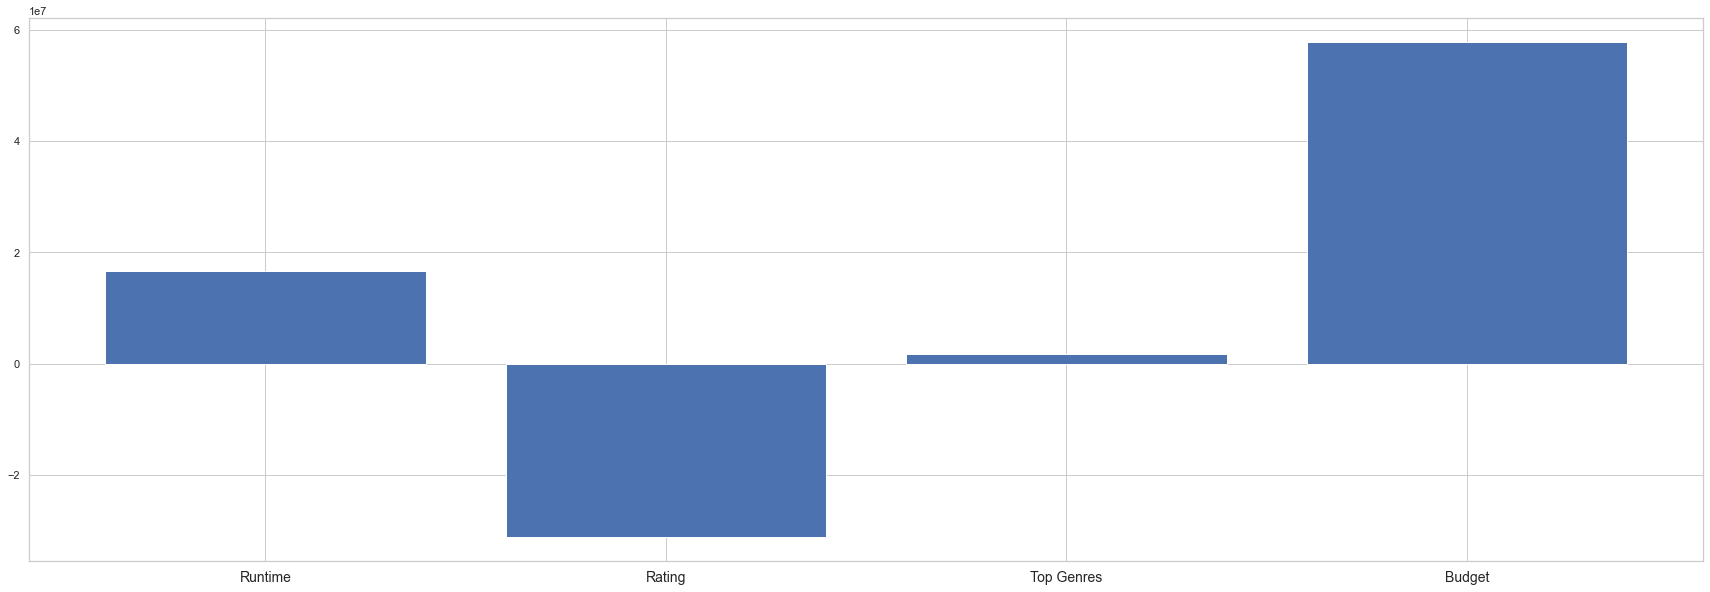

In [116]:
# Important as standardized so can see relative importance
plt.figure(figsize=(30,10))
plt.rc('xtick', labelsize=14)
plt.bar(X_columns,lm_reg.coef_)
plt.savefig("Feature_Plot_Ridge.pdf");

In [119]:
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

In [121]:
RMSE(lm_reg.predict(X_val_scaled),y_val) #final RMSE value

87195337.98480389